## NCARS DATASET

We confirm the shape of all .dat files first, if the below script does not print, we are good to go. Every .dat file has a data region (after header) that is a perfect multiple of 8 bytes

In [3]:
import os

base_folder = "/mnt/ssd/dataset_dvs/NCARS classifiaction Dataset/Prophesee_Dataset_n_cars"
folders = [
    os.path.join(base_folder, "n-cars_train", "background"),
    os.path.join(base_folder, "n-cars_train", "cars"),
    os.path.join(base_folder, "n-cars_test", "background"),
    os.path.join(base_folder, "n-cars_test", "cars"),
]

for folder in folders:
    files = sorted([f for f in os.listdir(folder) if f.endswith('.dat')])
    for fname in files:
        fpath = os.path.join(folder, fname)
        with open(fpath, 'rb') as f:
            # Header
            header_lines = []
            while True:
                pos = f.tell()
                line = f.readline()
                if not line.startswith(b"%"):
                    f.seek(pos)
                    break
                header_lines.append(line.strip())
            # Event type/size
            if header_lines:
                f.read(2)
            bof = f.tell()
            f.seek(0, 2)
            file_end = f.tell()
            data_region_size = file_end - bof

        if data_region_size % 8 != 0:
            print(f"{fpath}: data_region_size {data_region_size} NOT multiple of 8")


We check how many events per file, to see if many files with 0 events, also some visual to gain insight.

Dataset Summary:
                   count         mean          std    min      25%     50%  \
label                                                                        
Test Background   4211.0  4331.260983  4845.402200  500.0  1116.00  2513.0   
Test Cars         4396.0  3815.294359  3767.182017  500.0  1234.75  2557.5   
Train Background  7482.0  3371.345763  3903.214496  500.0   945.00  1875.0   
Train Cars        7940.0  4416.534005  4527.246231  500.0  1412.75  2977.5   

                      75%      max  
label                               
Test Background   5906.00  59249.0  
Test Cars         5068.00  34365.0  
Train Background  4208.00  40787.0  
Train Cars        5580.25  45885.0  


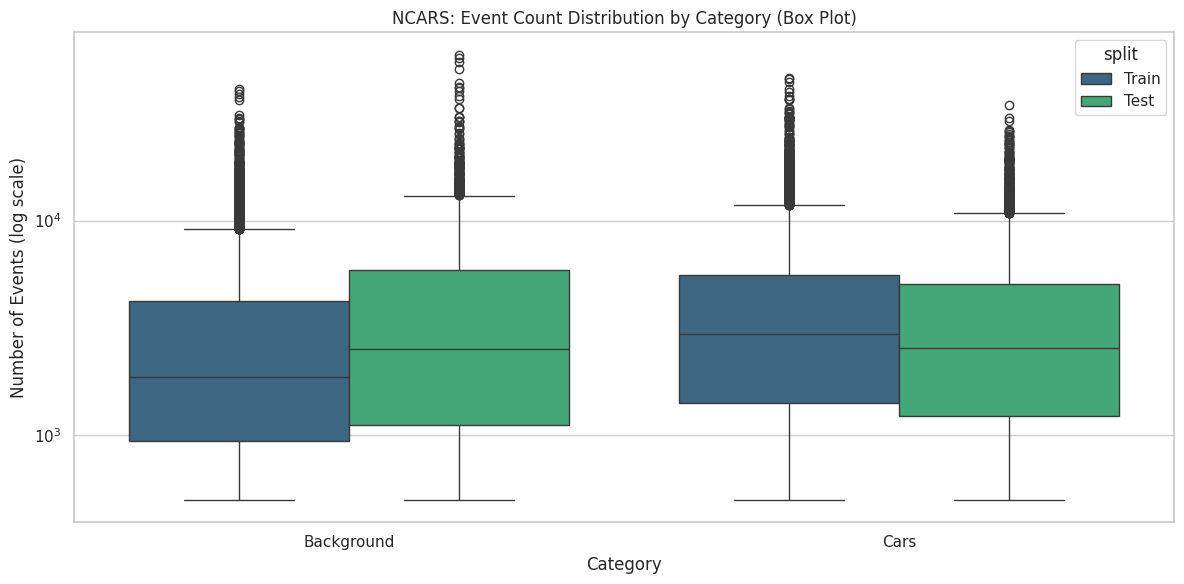

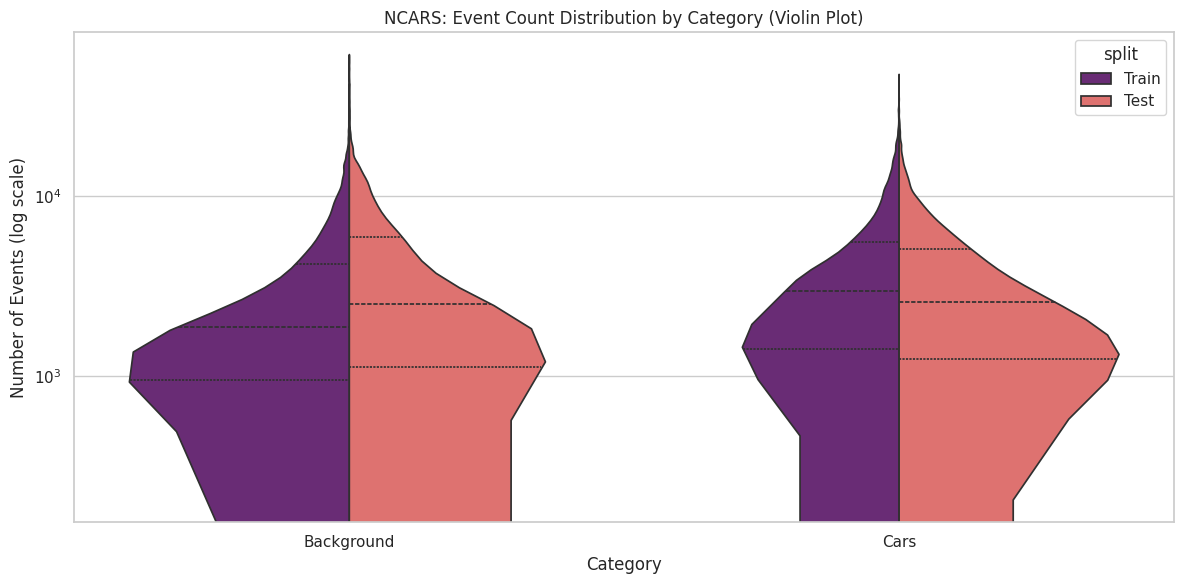

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def get_event_data(base_folder):
    """
    Crawls the NCARS directory structure to get event counts and labels for each file.
    """
    folders = {
        "Train Background": os.path.join(base_folder, "n-cars_train", "background"),
        "Train Cars":       os.path.join(base_folder, "n-cars_train", "cars"),
        "Test Background":  os.path.join(base_folder, "n-cars_test", "background"),
        "Test Cars":        os.path.join(base_folder, "n-cars_test", "cars"),
    }

    data = []

    for label, folder_path in folders.items():
        if not os.path.isdir(folder_path):
            print(f"Warning: Folder not found at {folder_path}")
            continue
            
        files = sorted([f for f in os.listdir(folder_path) if f.endswith('.dat')])
        for fname in files:
            fpath = os.path.join(folder_path, fname)
            with open(fpath, 'rb') as f:
                # Efficiently skip header
                pos_before_read = f.tell()
                line = f.readline()
                while line.startswith(b'%'):
                    pos_before_read = f.tell()
                    line = f.readline()
                f.seek(pos_before_read)

                # Skip evType/evSize if header existed
                if f.tell() > 0:
                    f.read(2)
                
                bof = f.tell()
                f.seek(0, 2)
                file_end = f.tell()
                n_events = (file_end - bof) // 8
                
                # Split label for easier plotting later
                split, category = label.split(" ")
                data.append({"events": n_events, "label": label, "split": split, "category": category})
                
    return pd.DataFrame(data)

def plot_distributions(df):
    """
    Generates a box plot and a violin plot to compare event count distributions.
    """
    if df.empty:
        print("DataFrame is empty. Cannot generate plots.")
        return

    # Set plot style
    sns.set_theme(style="whitegrid")

    # --- Plot 1: Box Plot ---
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="category", y="events", hue="split", palette="viridis")
    plt.yscale('log') # Use log scale due to wide range of event counts
    plt.title("NCARS: Event Count Distribution by Category (Box Plot)")
    plt.xlabel("Category")
    plt.ylabel("Number of Events (log scale)")
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Violin Plot ---
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x="category", y="events", hue="split", split=True, inner="quart", palette="magma")
    plt.yscale('log') # Use log scale
    plt.title("NCARS: Event Count Distribution by Category (Violin Plot)")
    plt.xlabel("Category")
    plt.ylabel("Number of Events (log scale)")
    plt.tight_layout()
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # IMPORTANT: Replace with the correct base path to your NCARS dataset
    base_folder = "/mnt/ssd/dataset_dvs/NCARS classifiaction Dataset/Prophesee_Dataset_n_cars"
    
    event_df = get_event_data(base_folder)
    
    # Print some basic stats
    if not event_df.empty:
        print("Dataset Summary:")
        print(event_df.groupby('label')['events'].describe())
        
        # Generate the plots
        plot_distributions(event_df)
    else:
        print("No data found. Please check the 'base_folder' path.")

We see that the minimun number of events is 500 for each as developers state “Recordings with less than 500 events were removed from the dataset.”

Now we visualize the events to confirm, if 

obj_004396_td.dat: max x = 48, max y = 61
obj_004397_td.dat: max x = 53, max y = 60
obj_004398_td.dat: max x = 62, max y = 57
obj_004399_td.dat: max x = 67, max y = 52


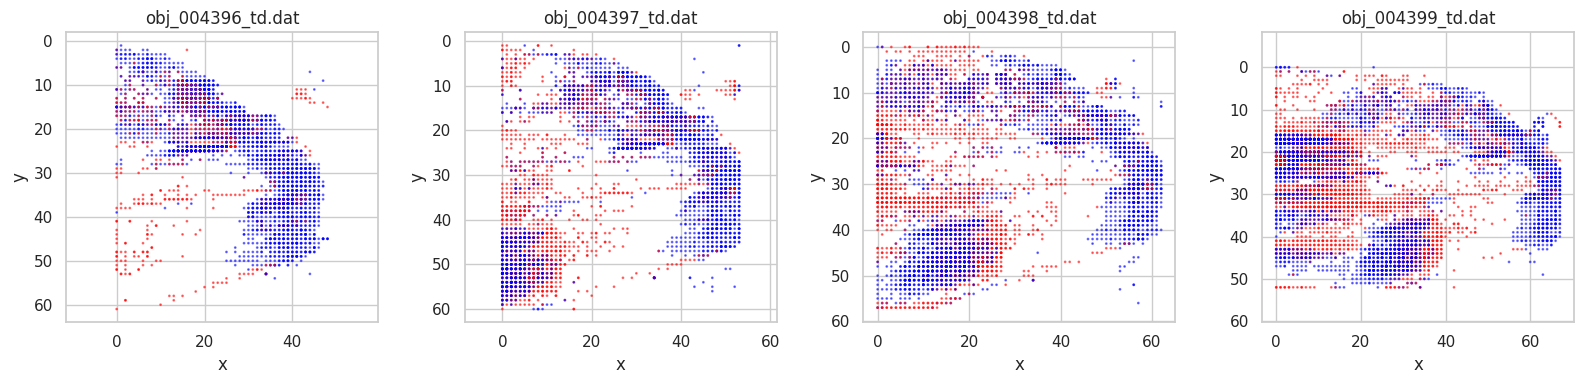

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_and_decode(fpath):
    with open(fpath, 'rb') as f:
        # Skip header
        while True:
            pos = f.tell()
            line = f.readline()
            if not line.startswith(b"%"):
                f.seek(pos)
                break
        # Skip event type/size bytes
        f.read(2)
        data = f.read()
    arr = np.frombuffer(data, dtype=np.uint32).reshape(-1, 2)
    ts, addr = arr[:, 0], arr[:, 1]
    # Decode addresses
    x = (addr & 0x00003FFF)
    y = (addr & 0x0FFFC000) >> 14
    p = -1 + 2 * ((addr & 0x10000000) >> 28).astype(np.int32)
    return x, y, p

folder = "/mnt/ssd/dataset_dvs/NCARS classifiaction Dataset/Prophesee_Dataset_n_cars/n-cars_train/cars"
files = sorted([f for f in os.listdir(folder) if f.endswith('.dat')])[:4]

plt.figure(figsize=(16,4))
for i, fname in enumerate(files):
    fpath = os.path.join(folder, fname)
    x, y, p = load_and_decode(fpath)
    print(f"{fname}: max x = {x.max()}, max y = {y.max()}")
    plt.subplot(1, 4, i+1)
    plt.scatter(x, y, s=1, c=p, cmap='bwr', alpha=0.5)
    plt.title(fname)
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
plt.tight_layout()
plt.show()

Above spike clouds show that car moving to the right, lets confirm the camera resolution now.

In [9]:
import os
import numpy as np

base_folder = "/mnt/ssd/dataset_dvs/NCARS classifiaction Dataset/Prophesee_Dataset_n_cars"
folders = [
    os.path.join(base_folder, "n-cars_train", "background"),
    os.path.join(base_folder, "n-cars_train", "cars"),
    os.path.join(base_folder, "n-cars_test", "background"),
    os.path.join(base_folder, "n-cars_test", "cars"),
]

global_max_x = 0
global_max_y = 0
global_min_x = float('inf')
global_min_y = float('inf')

for folder in folders:
    files = [f for f in os.listdir(folder) if f.endswith('.dat')]
    for fname in files:
        fpath = os.path.join(folder, fname)
        with open(fpath, 'rb') as f:
            # Skip header
            while True:
                pos = f.tell()
                line = f.readline()
                if not line.startswith(b"%"):
                    f.seek(pos)
                    break
            f.read(2)  # skip type/size bytes
            data = f.read()
        arr = np.frombuffer(data, dtype=np.uint32).reshape(-1, 2)
        addr = arr[:, 1]
        x = (addr & 0x00003FFF)
        y = (addr & 0x0FFFC000) >> 14
        if len(x) > 0:
            global_max_x = max(global_max_x, x.max())
            global_max_y = max(global_max_y, y.max())
            global_min_x = min(global_min_x, x.min())
            global_min_y = min(global_min_y, y.min())

print(f"Global min x: {global_min_x}, max x: {global_max_x}")
print(f"Global min y: {global_min_y}, max y: {global_max_y}")


Global min x: 0, max x: 119
Global min y: 0, max y: 99


Camera resolution is confirmed to be 120x100.

In [12]:
import torch
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

class NCARSDatasetWindowedRAM:
    def __init__(self, file_paths, label, window_ms=50):
        self.window_ms = window_ms
        self.file_infos = [(f, label) for f in file_paths]
        self.data = []
        self.index = []

        print(f"Loading and indexing {len(file_paths)} files...")
        for file_idx, (fpath, label) in enumerate(tqdm(self.file_infos, desc="Loading files")):
            with open(fpath, 'rb') as f:
                while True:
                    pos = f.tell()
                    line = f.readline()
                    if not line.startswith(b"%"):
                        f.seek(pos)
                        break
                f.read(2)
                data = f.read()
            arr = np.frombuffer(data, dtype=np.uint32).reshape(-1, 2)
            ts = arr[:, 0]
            addr = arr[:, 1]
            self.data.append({'ts': ts, 'addr': addr})

            if len(ts) == 0:
                continue
            t_min, t_max = ts[0], ts[-1]
            window_us = window_ms * 1000
            starts = np.arange(t_min, t_max, window_us)
            for s in starts:
                self.index.append((file_idx, s, s + window_us, label))

def cache_or_load_dataset(file_paths, cache_file, label, window_ms=50):
    if os.path.exists(cache_file):
        print(f"Cache file found: {cache_file}. Loading...")
        raw = torch.load(cache_file, weights_only=False)
        print("Loaded from cache.")
    else:
        print(f"No cache found. Building dataset (this may take a while)...")
        dataset = NCARSDatasetWindowedRAM(file_paths, label, window_ms=window_ms)
        raw = {
            'data': dataset.data,
            'index': dataset.index,
            'file_infos': dataset.file_infos,
            'window_ms': dataset.window_ms,
        }
        print(f"Saving cache to {cache_file} ...")
        torch.save(raw, cache_file)
        print("Dataset cached.")
    return raw

if __name__ == "__main__":
    base_folder = "/mnt/ssd/dataset_dvs/NCARS classifiaction Dataset/Prophesee_Dataset_n_cars"
    window_ms = 50

    # --- Make folders ---
    os.makedirs("caches", exist_ok=True)
    os.makedirs("figure", exist_ok=True)

    configs = [
        ("train_cars",       os.path.join(base_folder, "n-cars_train", "cars"),       1),
        ("train_background", os.path.join(base_folder, "n-cars_train", "background"), 0),
        ("test_cars",        os.path.join(base_folder, "n-cars_test", "cars"),        1),
        ("test_background",  os.path.join(base_folder, "n-cars_test", "background"),  0),
    ]

    for split_name, folder, label in configs:
        files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.dat')])
        cache_file = f"caches/ncars_{split_name}_win{window_ms}ms.pt"
        data = cache_or_load_dataset(files, cache_file, label, window_ms=window_ms)

        # Inspect and plot
        print(f"Total windows indexed: {len(data['index'])}")
        sample_idx = 0
        file_idx, t_start, t_end, label = data['index'][sample_idx]
        ts = data['data'][file_idx]['ts']
        addr = data['data'][file_idx]['addr']
        mask = (ts >= t_start) & (ts < t_end)
        x = (addr[mask] & 0x00003FFF)
        y = (addr[mask] & 0x0FFFC000) >> 14
        p = -1 + 2 * ((addr[mask] & 0x10000000) >> 28).astype(np.int32)
        print(f"Sample window {sample_idx}: file_idx={file_idx}, t=[{t_start},{t_end}), label={label}")
        print(f"x: {x[:10]}")
        print(f"y: {y[:10]}")
        print(f"t: {ts[mask][:10]}")
        print(f"p: {p[:10]}")
        print(f"Events in window: {mask.sum()}")

        # Histogram for this split
        counts = []
        for file_idx, t_start, t_end, _ in tqdm(data['index'], desc="Counting events"):
            ts = data['data'][file_idx]['ts']
            mask = (ts >= t_start) & (ts < t_end)
            counts.append(mask.sum())
        plt.figure()
        plt.hist(counts, bins=100, log=True)
        plt.xlabel("Number of events per 50 ms window")
        plt.ylabel("Frequency (log)")
        plt.title(f"Event counts per window (50 ms) - {split_name}")
        plt.savefig(f"figure/ncars_{split_name}_hist_win{window_ms}ms.png")
        plt.close()


Cache file found: caches/ncars_train_cars_win50ms.pt. Loading...
Loaded from cache.
Total windows indexed: 15880
Sample window 0: file_idx=0, t=[0,50000), label=1
x: [34 15 13 29 38 36 31 28 33 14]
y: [30 16 21 25 47 35 43 41 38 16]
t: [  0  11  16  49  50  68 153 165 172 251]
p: [-1 -1  1 -1 -1 -1 -1 -1  1 -1]
Events in window: 1738


Counting events: 100%|██████████| 15880/15880 [00:00<00:00, 39062.87it/s]


No cache found. Building dataset (this may take a while)...
Loading and indexing 7482 files...


Loading files: 100%|██████████| 7482/7482 [00:04<00:00, 1696.12it/s]


Saving cache to caches/ncars_train_background_win50ms.pt ...
Dataset cached.
Total windows indexed: 14964
Sample window 0: file_idx=0, t=[0,50000), label=0
x: [14 19  2 17 25 17 11 27 15 27]
y: [ 2 18 38 24  6 35 22 44  2  6]
t: [  0 116 263 286 287 326 327 368 382 383]
p: [-1  1  1 -1 -1 -1 -1 -1  1  1]
Events in window: 690


Counting events: 100%|██████████| 14964/14964 [00:00<00:00, 49492.03it/s]


No cache found. Building dataset (this may take a while)...
Loading and indexing 4396 files...


Loading files: 100%|██████████| 4396/4396 [00:01<00:00, 2593.58it/s]


Saving cache to caches/ncars_test_cars_win50ms.pt ...
Dataset cached.
Total windows indexed: 8792
Sample window 0: file_idx=0, t=[0,50000), label=1
x: [30 21 14 12 23 14 21  7 29 13]
y: [14 29 14 17 32 17 15 23 17 26]
t: [   0  230  308  651  659  745  773 1001 1832 1983]
p: [-1 -1 -1  1  1 -1 -1 -1 -1 -1]
Events in window: 245


Counting events: 100%|██████████| 8792/8792 [00:00<00:00, 53223.18it/s]


No cache found. Building dataset (this may take a while)...
Loading and indexing 4211 files...


Loading files: 100%|██████████| 4211/4211 [00:01<00:00, 2581.17it/s]


Saving cache to caches/ncars_test_background_win50ms.pt ...
Dataset cached.
Total windows indexed: 8422
Sample window 0: file_idx=0, t=[0,50000), label=0
x: [ 14  40  58 101   5   9  24   8  20  94]
y: [ 0 20 48 16 17  2  7  5 32  0]
t: [   0    1   46  240  246  248  416  492  571 1216]
p: [ 1  1 -1 -1  1  1 -1  1 -1 -1]
Events in window: 523


Counting events: 100%|██████████| 8422/8422 [00:00<00:00, 49487.71it/s]


## DATASET PREPARATION

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class NCARSDictDataset(Dataset):
    def __init__(self, cached_data):
        self.data_cache = cached_data['data']
        self.index = cached_data['index']

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, t_start, t_end, label = self.index[idx]
        ts = self.data_cache[file_idx]['ts']
        addr = self.data_cache[file_idx]['addr']
        mask = (ts >= t_start) & (ts < t_end)
        x = (addr[mask] & 0x00003FFF)
        y = (addr[mask] & 0x0FFFC000) >> 14
        p = -1 + 2 * ((addr[mask] & 0x10000000) >> 28).astype(np.int32)
        return {
            'x': torch.from_numpy(x.copy()),
            'y': torch.from_numpy(y.copy()),
            't': torch.from_numpy(ts[mask].copy()),
            'p': torch.from_numpy(p.copy()),
            'label': torch.tensor(label, dtype=torch.long)
        }

def collate_fn_padded(batch):
    max_len = max([sample['x'].shape[0] for sample in batch])
    batch_size = len(batch)
    x_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    y_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    t_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    p_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    mask = torch.zeros((batch_size, max_len), dtype=torch.bool)
    labels = torch.zeros((batch_size,), dtype=torch.long)
    for i, sample in enumerate(batch):
        n_events = sample['x'].shape[0]
        x_padded[i, :n_events] = sample['x']
        y_padded[i, :n_events] = sample['y']
        t_padded[i, :n_events] = sample['t']
        p_padded[i, :n_events] = sample['p']
        mask[i, :n_events] = True
        labels[i] = sample['label']
    return {
        'x': x_padded,
        'y': y_padded,
        't': t_padded,
        'p': p_padded,
        'mask': mask,
        'label': labels
    }

# --- Main script to create DataLoaders ---
if __name__ == '__main__':
    window_ms = 50
    CACHE_DIR = "/workspace/caches"
    cache_paths = {
        'train_cars':       f"{CACHE_DIR}/ncars_train_cars_win{window_ms}ms.pt",
        'train_background': f"{CACHE_DIR}/ncars_train_background_win{window_ms}ms.pt",
        'test_cars':        f"{CACHE_DIR}/ncars_test_cars_win{window_ms}ms.pt",
        'test_background':  f"{CACHE_DIR}/ncars_test_background_win{window_ms}ms.pt"
    }

    try:
        # --- TRAIN SET ---
        train_cars_data = torch.load(cache_paths['train_cars'], weights_only=False)
        train_bg_data = torch.load(cache_paths['train_background'], weights_only=False)
        combined_train_data = {
            'data': train_cars_data['data'] + train_bg_data['data'],
            'index': train_cars_data['index'] + [
                (idx + len(train_cars_data['data']), s, e, l)
                for idx, s, e, l in train_bg_data['index']
            ]
        }
        train_dataset = NCARSDictDataset(combined_train_data)
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_padded)
        print(f"Train DataLoader ready: {len(train_dataset)} windows")

        # --- TEST SET ---
        test_cars_data = torch.load(cache_paths['test_cars'], weights_only=False)
        test_bg_data = torch.load(cache_paths['test_background'], weights_only=False)
        combined_test_data = {
            'data': test_cars_data['data'] + test_bg_data['data'],
            'index': test_cars_data['index'] + [
                (idx + len(test_cars_data['data']), s, e, l)
                for idx, s, e, l in test_bg_data['index']
            ]
        }
        test_dataset = NCARSDictDataset(combined_test_data)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_padded)
        print(f"Test DataLoader ready: {len(test_dataset)} windows")

        # --- Inspect one batch for each ---
        print("\n--- Inspecting one train batch ---")
        for batch in train_loader:
            print({k: v.shape for k, v in batch.items()})
            print("Train labels:", batch['label'])
            break

        print("\n--- Inspecting one test batch ---")
        for batch in test_loader:
            print({k: v.shape for k, v in batch.items()})
            print("Test labels:", batch['label'])
            break

    except FileNotFoundError as e:
        print(f"Error: Cache file not found. Please run the caching script first.")
        print(f"Missing file: {e.filename}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Train DataLoader ready: 30844 windows
Test DataLoader ready: 17214 windows

--- Inspecting one train batch ---
{'x': torch.Size([8, 8628]), 'y': torch.Size([8, 8628]), 't': torch.Size([8, 8628]), 'p': torch.Size([8, 8628]), 'mask': torch.Size([8, 8628]), 'label': torch.Size([8])}
Train labels: tensor([1, 0, 0, 1, 1, 1, 0, 0])

--- Inspecting one test batch ---
{'x': torch.Size([8, 381]), 'y': torch.Size([8, 381]), 't': torch.Size([8, 381]), 'p': torch.Size([8, 381]), 'mask': torch.Size([8, 381]), 'label': torch.Size([8])}
Test labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])


## STDP LEARNING 

Purpose:

- This is a self-supervised or unsupervised STDP training run.

- The goal is not classification but feature learning—you want the kernels to adapt to patterns in the training data, not to "predict" or "evaluate" on test data yet.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ---- (1) STDP Layer (your code, with minor tweaks to print less for large data) ----
class EventConv2dSTDP(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 height=100, width=120, threshold=1.0, stdp_eta=0.05, stdp_tau=20.0, weight_decay=0.001):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)
        self.height = height
        self.width = width
        self.threshold = threshold
        self.stdp_eta = stdp_eta
        self.stdp_tau = stdp_tau
        self.weight_decay = weight_decay

        self.weight = nn.Parameter(
            torch.full((out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]), 0.4),
            requires_grad=False
        )
        self.out_h = (self.height + 2*self.padding[0] - self.kernel_size[0]) // self.stride[0] + 1
        self.out_w = (self.width + 2*self.padding[1] - self.kernel_size[1]) // self.stride[1] + 1

    def forward(self, batch):
        # Print device at start of forward
        print(f"Running EventConv2dSTDP forward on device: {self.weight.device}")

        x = batch['x']
        y = batch['y']
        t = batch['t']
        p = batch['p']
        mask = batch['mask']
        batch_size = x.shape[0]

        channel_indices = ((p + 1) // 2).long()
        output_spikes_batch = [[] for _ in range(batch_size)]

        last_pre_spike = torch.full((batch_size, self.in_channels, self.height, self.width), -float('inf'), device=self.weight.device)
        last_post_spike = torch.full((batch_size, self.out_channels, self.out_h, self.out_w), -float('inf'), device=self.weight.device)

        for b_idx in range(batch_size):
            mem = torch.zeros((self.out_channels, self.out_h, self.out_w), device=self.weight.device)
            num_events_in_sample = mask[b_idx].sum()
            sorted_indices = torch.argsort(t[b_idx, :num_events_in_sample])

            # Print only first and last sample
            if b_idx == 0:
                print(f"\n[Sample {b_idx} initial weights]\n", self.weight.clone())

            for i in range(num_events_in_sample):
                event_idx = sorted_indices[i]
                xi, yi, ti, chi = (
                    x[b_idx, event_idx].item(),
                    y[b_idx, event_idx].item(),
                    t[b_idx, event_idx].item(),
                    channel_indices[b_idx, event_idx].item()
                )
                last_pre_spike[b_idx, chi, yi, xi] = ti

                y_out = yi // self.stride[0]
                x_out = xi // self.stride[1]
                ky_start = max(0, -y_out)
                kx_start = max(0, -x_out)
                ky_end = min(self.kernel_size[0], self.out_h - y_out)
                kx_end = min(self.kernel_size[1], self.out_w - x_out)
                if ky_start < ky_end and kx_start < kx_end:
                    mem[:, y_out:y_out+ky_end, x_out:x_out+kx_end] += self.weight[:, chi, ky_start:ky_end, kx_start:kx_end]
                spiking = mem >= self.threshold
                if spiking.any():
                    coords = torch.nonzero(spiking, as_tuple=False)
                    for out_ch, out_y, out_x in coords.tolist():
                        output_spikes_batch[b_idx].append((ti, out_x, out_y, out_ch))
                        last_post_spike[b_idx, out_ch, out_y, out_x] = ti
                        for chi2 in range(self.in_channels):
                            for ky in range(self.kernel_size[0]):
                                for kx in range(self.kernel_size[1]):
                                    in_y = (out_y * self.stride[0] + ky - self.padding[0])
                                    in_x = (out_x * self.stride[1] + kx - self.padding[1])
                                    if 0 <= in_y < self.height and 0 <= in_x < self.width:
                                        t_pre = last_pre_spike[b_idx, chi2, in_y, in_x]
                                        t_post = ti
                                        if t_pre > -float('inf') and abs(t_post - t_pre) < 1e5:
                                            delta_t = t_post - t_pre
                                            if delta_t >= 0:
                                                dw = self.stdp_eta * torch.exp(-delta_t / self.stdp_tau)
                                            else:
                                                dw = -self.stdp_eta * torch.exp(delta_t / self.stdp_tau)
                                            self.weight[out_ch, chi2, ky, kx] += dw
                                            # print(f"STDP update: w[{out_ch},{chi2},{ky},{kx}] += {dw:.5f} (Δt={delta_t})")
                    mem[spiking] = 0.0
            self.weight.mul_(1 - self.weight_decay)
            self.weight.data.clamp_(0, 1)
            if b_idx in (0, batch_size - 1):
                print(f"Sample {b_idx}: {num_events_in_sample} events, {len(output_spikes_batch[b_idx])} output spikes.")
                print("[Sample weights after decay/clamp]\n", self.weight.clone())
        return output_spikes_batch

# ---- (2) NCARS DataLoader (from your previous working code) ----
class NCARSDictDataset(torch.utils.data.Dataset):
    def __init__(self, cached_data):
        self.data_cache = cached_data['data']
        self.index = cached_data['index']
    def __len__(self):
        return len(self.index)
    def __getitem__(self, idx):
        file_idx, t_start, t_end, label = self.index[idx]
        ts = self.data_cache[file_idx]['ts']
        addr = self.data_cache[file_idx]['addr']
        mask = (ts >= t_start) & (ts < t_end)
        x = (addr[mask] & 0x00003FFF)
        y = (addr[mask] & 0x0FFFC000) >> 14
        p = -1 + 2 * ((addr[mask] & 0x10000000) >> 28).astype(np.int32)
        return {
            'x': torch.from_numpy(x.copy()),
            'y': torch.from_numpy(y.copy()),
            't': torch.from_numpy(ts[mask].copy()),
            'p': torch.from_numpy(p.copy()),
            'label': torch.tensor(label, dtype=torch.long)
        }

def collate_fn_padded(batch):
    max_len = max([sample['x'].shape[0] for sample in batch])
    batch_size = len(batch)
    x_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    y_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    t_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    p_padded = torch.zeros((batch_size, max_len), dtype=torch.long)
    mask = torch.zeros((batch_size, max_len), dtype=torch.bool)
    labels = torch.zeros((batch_size,), dtype=torch.long)
    for i, sample in enumerate(batch):
        n_events = sample['x'].shape[0]
        x_padded[i, :n_events] = sample['x']
        y_padded[i, :n_events] = sample['y']
        t_padded[i, :n_events] = sample['t']
        p_padded[i, :n_events] = sample['p']
        mask[i, :n_events] = True
        labels[i] = sample['label']
    return {
        'x': x_padded,
        'y': y_padded,
        't': t_padded,
        'p': p_padded,
        'mask': mask,
        'label': labels
    }

# ---- (3) Load Cache Data and Build Loader ----
window_ms = 50
CACHE_DIR = "/workspace/caches"
cache_paths = {
    'train_cars':       f"{CACHE_DIR}/ncars_train_cars_win{window_ms}ms.pt",
    'train_background': f"{CACHE_DIR}/ncars_train_background_win{window_ms}ms.pt",
}
train_cars_data = torch.load(cache_paths['train_cars'], weights_only=False)
train_bg_data = torch.load(cache_paths['train_background'], weights_only=False)
combined_train_data = {
    'data': train_cars_data['data'] + train_bg_data['data'],
    'index': train_cars_data['index'] + [
        (idx + len(train_cars_data['data']), s, e, l)
        for idx, s, e, l in train_bg_data['index']
    ]
}
train_dataset = NCARSDictDataset(combined_train_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn_padded)

# ---- (4) Train for One Unsupervised Epoch ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

layer = EventConv2dSTDP(
    in_channels=2, out_channels=8, kernel_size=5, stride=1, padding=2,
    height=100, width=120, threshold=1.0, stdp_eta=0.03, stdp_tau=30.0, weight_decay=0.001
).to(device)
with torch.no_grad():
    layer.weight.uniform_(0.1, 0.3)
print("\n[Initial weights snapshot]\n", layer.weight[:, 0, :, :])

for i, batch in enumerate(train_loader):
    # Move all batch tensors to device
    for k in batch:
        if isinstance(batch[k], torch.Tensor):
            batch[k] = batch[k].to(device)
    # Print to confirm batch is on same device
    if i == 0:
        print("Batch tensors are on device:", batch['x'].device)
    layer(batch)
    if (i+1) % 50 == 0:
        print(f"Processed batch {i+1} / {len(train_loader)}")
    if i == 149:  # Just run 150 for fast test. Remove or change for full epoch.
        break

print("[Finished one epoch of unsupervised STDP training]\n")

# >>>>>>>>>>>>>>>>>>>>  ADD THIS LINE <<<<<<<<<<<<<<<<<<<<<<
torch.save(layer.state_dict(), "weights/stdp_trained_weights.pth")
print("[Saved learned STDP weights to stdp_trained_weights.pth]")

# ---- (5) Plot kernels ----
def plot_kernels(layer, ch=0, title="ON (ch=0) kernels"):
    W = layer.weight[:, ch, :, :].cpu().detach().numpy()
    n = W.shape[0]
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for i in range(n):
        axes[i].imshow(W[i], cmap='viridis', interpolation='nearest')
        axes[i].set_title(f'Kernel {i}')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("[Plotting learned ON (ch=0) kernels:]")
plot_kernels(layer, ch=0, title="Learned ON (ch=0) kernels")
print("[Plotting learned OFF (ch=1) kernels:]")
plot_kernels(layer, ch=1, title="Learned OFF (ch=1) kernels")


CUDA available: True
Using device: cuda

[Initial weights snapshot]
 tensor([[[0.1886, 0.1829, 0.2170, 0.1208, 0.1823],
         [0.1296, 0.2734, 0.2671, 0.1211, 0.2452],
         [0.1728, 0.1102, 0.1414, 0.2084, 0.2151],
         [0.1602, 0.2580, 0.2446, 0.2120, 0.2907],
         [0.1173, 0.1541, 0.1054, 0.2585, 0.1436]],

        [[0.1355, 0.1789, 0.2647, 0.2975, 0.2672],
         [0.1147, 0.2606, 0.1461, 0.2496, 0.2709],
         [0.2386, 0.2068, 0.1405, 0.2065, 0.2142],
         [0.2646, 0.1149, 0.1084, 0.1034, 0.2115],
         [0.1513, 0.2503, 0.1468, 0.1538, 0.1158]],

        [[0.1006, 0.1432, 0.1978, 0.1115, 0.2532],
         [0.2639, 0.2593, 0.1551, 0.2779, 0.1564],
         [0.2382, 0.1849, 0.1774, 0.1461, 0.2170],
         [0.2743, 0.2865, 0.1878, 0.1772, 0.1685],
         [0.2762, 0.2941, 0.1297, 0.2267, 0.2204]],

        [[0.2138, 0.2506, 0.2115, 0.1489, 0.1668],
         [0.2006, 0.1651, 0.2771, 0.1000, 0.1927],
         [0.2719, 0.2010, 0.1492, 0.2058, 0.2972],
       

RuntimeError: Parent directory weights does not exist.